# Active Learning on Molecular Systems with GraphDot, xTB, ASE, and scikit-learn

Original Post: 3/11/2020

Updated: 4/10/2020 

## Introduction

Since the end of my PhD (Aug 2019), I have been interested in combining active learning with quantum calculations to explore configuration space in molecular systems. The goal of this post is to explore active learning on a simple system and to put a few ideas out there for people to think about and expand on. The other reason I wanted to make this post is that I think it is really cool how easily GraphDot/xTB/ASE/scikit-learn can be used together, so I thought I would share by example.

I want to thank [Yu-Hang Tang](https://crd.lbl.gov/departments/computational-science/ccmc/staff/alvarez-fellows/yu-hang-tang/) for all the help with the graph kernel, none of this would have been possible otherwise. If you want to learn more about the graph kernel, check out this [publication](http://dx.doi.org/10.1063/1.5078640). 

If you have any questions or comments shoot me an email bwood@lbl.gov.

## Dependencies

All dependencies can be pip installed with the exception of xTB, which can now be install with [conda](https://github.com/grimme-lab/xtb), although I used a version I compiled. Additionally, the methods I used from GraphDot require a GPU.   
- [GraphDot](https://graphdot.readthedocs.io/en/latest/) 
- [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html)
- [ASE](https://wiki.fysik.dtu.dk/ase/index.html)
- scikit-learn
- Numpy
- Matplotlib
- tqdm 

# Conformations of Polyethylene

## Description of the system

The toy problem I chose to explore is approximating the energy functional of an ensemble of polyethylene chain conformations. I defined the problem as follows. All chains are made up of 3 monomers — 6 carbon atoms. The rationale for short chains is to keep the degrees of freedom manageable for example purposes. Each chain consists of three C-C-C-C torsion angles ($\phi$$_i$, $\phi$$_j$, $\phi$$_k$) and a conformation is defined as a unique set of the three torsion angles {$\phi$$_i$, $\phi$$_j$, $\phi$$_k$}. I discretized the torsion angle distribution to contain 36 states equally spaced by 10 degrees. The ensemble of conformations is generated by sampling over all of the discrete torsional configurations, so there are ~ $36^3$ conformations — some of these are not unique because of symmetry.

## Description of the active learning algorithm

The objective is to find a surrogate model for calculating the energy of a chain conformation. Generally speaking, an energy evaluation with density functional theory (DFT) or another level of quantum chemistry is computationally expensive, so if we can generate a reasonable energy prediction (or predict another property of interest) with a machine learning model it saves computational time and expands the systems we can study. In this example, I generate a graph representation of the different conformations using GraphDot and then use a graph kernel with scikit-learn’s Gaussian Process Regression (GPR) to predict energies. I could easily calculate all the confomer energies with xTB; however, if I wanted to use DFT or look at larger systems that would not be possible. As a result, I wanted to implement an active learning strategy. The active learning algorithm I employ is an iterative process where ~1000 conformations are predicted each step, and the 300 conformers with the largest prediction uncertainties are fed back into the training data for the next step. This procedure is intended to ensure that the model sees data that will maximally improve the model each step.

## Imports

In [1]:
import numpy as np
import os
import time
from tqdm import tqdm

In [2]:
import xtb
from xtb import GFN2

import ase
from ase.io import read, write
from ase.units import Hartree
from ase.optimize import BFGSLineSearch

In [3]:
from graphdot import Graph
from graphdot.graph.adjacency import AtomicAdjacency
from graphdot.kernel.molecular import Tang2019MolecularKernel
from graphdot.kernel.basekernel import KroneckerDelta, SquareExponential, TensorProduct
from graphdot.kernel.marginalized import MarginalizedGraphKernel

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Generate dataset via torsional configurations

Torsion angles range from 0 to 360 degrees or depending on the convention from -180 to 180 degrees. For the purposes of this demo I am going to use 0 to 360 because it fits naturally with the convention ASE uses.

In [6]:
torsion_angles = np.linspace(0.0, 350.0, num=36)

In [7]:
torsion_angles

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350.])

Generate an array of all combinations for 3 torsion angles ~46,000
this includes all combinations, not all will be unique because of symmetry

In [8]:
tor_combinations = np.zeros((46656, 3))

In [9]:
count = 0
for i in torsion_angles:
    for j in torsion_angles:
        for k in torsion_angles:
            tor_combinations[count] = [i, j, k]
            count += 1

Read in the polyethylene molecule

In [10]:
pe_mol = read("pe_n6.xyz", format="xyz")

Set the energy calculator

In [11]:
pe_mol.set_calculator(GFN2())

Check how long it takes to calculate the energy

In [12]:
%time pe_mol.get_potential_energy()

CPU times: user 32.6 ms, sys: 8.23 ms, total: 40.9 ms
Wall time: 25 ms


-543.9429310420319

In [13]:
relax = BFGSLineSearch(pe_mol)

In [14]:
relax.run(fmax=0.05)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 11:21:41     -543.942931*       0.7441
BFGSLineSearch:    1[  2] 11:21:41     -544.038490*       0.5208
BFGSLineSearch:    2[  4] 11:21:41     -544.057613*       0.1229
BFGSLineSearch:    3[  6] 11:21:41     -544.058974*       0.0662
BFGSLineSearch:    4[  8] 11:21:41     -544.059370*       0.0572
BFGSLineSearch:    5[ 10] 11:21:41     -544.059850*       0.0372


True

In [15]:
pe_mol.get_potential_energy()

-544.0598501831128

## Helper functions for generating data

In [16]:
# this function rotates all the torsion angles of the base molecule to the desired angles
def rotate_all_torsions(base_mol, tor_atoms, tor_angles, rot_indices):
    # copy base mol
    rot_mol = base_mol.copy()
    # loop through all the torsion angles in the conformer
    for i, atom in enumerate(tor_atoms):
        rot_mol.set_dihedral(a1=atom[0], a2=atom[1], a3=atom[2], a4=atom[3], 
                             angle=tor_angles[i], indices=rot_indices[i])
    return rot_mol

In [17]:
# this function generates all the rotated molecues and calculates their energy
# additionally an energy cutoff of 1 eV is imposed
def generate_data(base_mol, tors_list, tor_atoms, rot_indicies, sample_num):
    mol_list = []
    with tqdm(total=sample_num) as pbar:
        for angles in tors_list:
            rot_mol = rotate_all_torsions(base_mol, tor_atoms, angles, rot_indicies)
            rot_mol.set_calculator(GFN2())
            r_energy = rot_mol.get_potential_energy()
            # energy cutoff of -543.0 eV
            if r_energy < -543.0:
                mol_list.append(rot_mol)
                pbar.update(1)
            else:
                continue
            if len(mol_list) == sample_num:
                break
            else:
                continue
    return mol_list

## Specify atoms involved in each torsion angle

In [18]:
# these are specific for this particular molecule and xyz file ordering
pe_n6_tor_atoms = [[0, 1, 5, 8], [1, 5, 8, 11], [5, 8, 11, 14]]

In [19]:
# these are specific for this particular molecule and xyz file ordering
pe_n6_tor_indices=[[8,9,10,11,12,13,14,15,16,17,18,19], [11,12,13,14,15,16,17,18,19], [14,15,16,17,18,19]]

## Generate and write data

In [20]:
# shuffle torsion combinations
random_tors = np.copy(tor_combinations)
np.random.shuffle(random_tors)

In [21]:
# this took 6 mins to run

**Comment on calculating all the energies at once**: Ideally, I would calculate energies on the fly in the active learning loop; however, for simplicity and because of the energy cutoff I am using I did everything at once. If I had done energy calculations in the active learning loop I would have saved myself 7000 energy evaluations — which can save a substantial amount of computational time depending on the method used.

## Read molecule data and generate graphs

In [22]:
%time mol_list = read("./data/pe_13k_dataset.xyz", index=":", format="xyz")

CPU times: user 5.53 s, sys: 259 ms, total: 5.78 s
Wall time: 5.77 s


In [23]:
# parameter for generating graphs
adj = AtomicAdjacency(shape='tent2', zoom=2.0)

In [24]:
# this function gets the input graphs and target energies
def get_xy_data(mols, adj):
    # shuffle the mols again
    random_mols = np.copy(mols)
    np.random.shuffle(random_mols)
    energy_array = np.array([mol.get_potential_energy() for mol in mols])
    graph_array = np.array([Graph.from_ase(mol, adjacency=adj) for mol in mols])
    return graph_array, energy_array

In [25]:
%time graphs, energies = get_xy_data(mol_list, adj)

CPU times: user 47.3 s, sys: 367 ms, total: 47.6 s
Wall time: 47.6 s


## Define the graph kernel

In [26]:
mol_kernel = Tang2019MolecularKernel(edge_length_scale=0.02, stopping_probability=0.01)

In order to use scikit-learn's GPR we need to to define a MarginalizedGraphKernel object. The kernel defined below is essentiually the same as the Tang2019MolecularKernel. I double check that assumption below.

In [27]:
kernel = MarginalizedGraphKernel(node_kernel=TensorProduct(element=KroneckerDelta(0.2)), 
                                 edge_kernel=TensorProduct(length=SquareExponential(0.02)), 
                                 q=0.01)

## Check graphs and visualize similarity matrix

In [28]:
try_graphs = graphs[:500]

In [29]:
try_energies = energies[:500]

In [30]:
R_mol = mol_kernel(try_graphs, lmin=1).astype(np.float)

In [31]:
D_mol = R_mol.diagonal()**-0.5

In [32]:
K_mol = D_mol[:, None] * R_mol * D_mol[None, :]

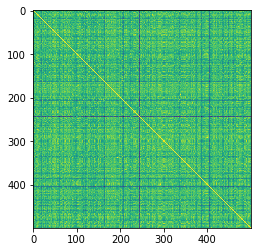

In [33]:
# visualize the similarity matrix
plt.imshow(K_mol)

In [34]:
K_mol.max()

1.000000173664869

In [35]:
K_mol.min()

0.8706799071173481

In [36]:
R = kernel(try_graphs, lmin=1).astype(np.float)

In [37]:
D = R.diagonal()**-0.5

In [38]:
K = D[:, None] * R * D[None, :]

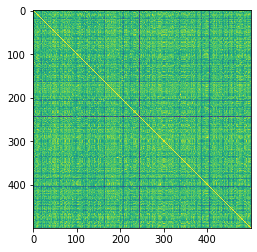

In [39]:
# visualize the similarity matrix
plt.imshow(K)

The yellow diagonal represents when conformers are compared to themselves

In [40]:
K.max()

1.000000249324106

In [41]:
K.min()

0.8706799071173481

The minimum similarity is fairly high, which isn't that surprising considering I am comparing the same molecule just with different torsional rotations.

## Calculate a specific torsion potential for benchmarking

To track how the model improves at each step, I generate the inputs and targets for a specific torsion potential to benchmark against. Arbitrarily, I chose the central torsion angle $\phi$$_j$, leaving $\phi$$_i$ and $\phi$$_k$ fixed. In the future, it would be nice to guarantee these benchmarking data points were held out of the training set, right now, they may or may not be included.

In [42]:
def get_torsion_pot(base_mol, tor_atoms, tor_angles, rot_indices, adj):
    tor_graphs = []
    tor_energies = []
    for angle in tor_angles:
        rot_mol = rotate_all_torsions(base_mol, tor_atoms, [angle], rot_indices)
        rot_mol.set_calculator(GFN2())
        tor_energies.append(rot_mol.get_potential_energy())
        tor_graphs.append(Graph.from_ase(rot_mol, adjacency=adj))
    return tor_energies, tor_graphs

In [43]:
# these are specific for this particular molecule and xyz file ordering
pe_t2_tor_atoms = [[1, 5, 8, 11]]

In [44]:
# these are specific for this particular molecule and xyz file ordering
pe_t2_tor_indices=[[11,12,13,14,15,16,17,18,19]]

In [45]:
tor_pot_angles = np.linspace(0.0, 360.0, num=37)

In [46]:
tor_pot_sp_energies, tor_pot_graphs = get_torsion_pot(pe_mol, pe_t2_tor_atoms, tor_pot_angles, pe_t2_tor_indices, adj)

## Active learning object

This is a simple class to help organize the active learning loop. ActiveGPR initializes a scikit-learn GPR model and has train, explore, updata_data, and calc_metrics methods.  

In [47]:
class ActiveGPR():
    def __init__(self, kernel, X_train, y_train, X_val, y_val, X_tor_pot):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_tor_pot = X_tor_pot
        self.uncertain = None
        # the default alpha value needs to be adjusted and 
        # normalize y is turned on because our energies do not have a mean of zero
        self.gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=0.02, normalize_y=True)
        self.metrics = {"step": [], "rmse": [], "mae": [], "r2": []}
        self.pred_pot = []
        self.step = 0
        
    def train(self):
        self.gpr.fit(self.X_train, self.y_train);
        self.calc_metrics(self.X_val, self.y_val)
        self.pred_pot.append(self.gpr.predict(self.X_tor_pot, return_std=True))
        self.step += 1
    
    def explore(self, X_new, sample_num=300):
        y_pred, y_std = self.gpr.predict(X_new, return_std=True)
        # np.argsort sorts from min to max so selecting from the end of array gives the
        # the max uncertainty
        uncertain_indexes = np.argsort(y_std)
        self.uncertain = uncertain_indexes[(len(uncertain_indexes) - sample_num):]

    def update_data(self, X, y):
        X_new = np.array(X)[self.uncertain]
        y_new = np.array(y)[self.uncertain]
        X_train = np.concatenate((self.X_train, X_new), axis=0)
        y_train = np.concatenate((self.y_train, y_new), axis=0)
        # shuffle data
        shuffle_ind = np.arange(len(X_train))
        np.random.shuffle(shuffle_ind)
        self.X_train = X_train[shuffle_ind]
        self.y_train = y_train[shuffle_ind]
        
    def calc_metrics(self, X, y):
        y_pred = self.gpr.predict(X)
        r2 = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred, squared=False) 
        mae = mean_absolute_error(y, y_pred)
        self.metrics["rmse"].append(rmse)
        self.metrics["mae"].append(mae)
        self.metrics["r2"].append(r2)

## Active learning loop

In [48]:
# define train, val, and test sets
def train_val_test_split(energies, graphs, val_size, test_size, initial_size, active_size):
    X_test = graphs[:test_size]
    y_test = energies[:test_size]
    X_val = graphs[test_size:(test_size + val_size)]
    y_val = energies[test_size:(test_size + val_size)]
    # returns the train set
    train_size = int(len(energies) - (test_size + val_size))
    splits = np.arange(initial_size, train_size, active_size)
    X_train_set = np.split(graphs[(test_size + val_size):], splits, axis=0)
    y_train_set = np.split(energies[(test_size + val_size):], splits, axis=0)
    return X_train_set, y_train_set, X_val, y_val, X_test, y_test

In [49]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(energies, graphs, 1000, 1000, 1000, 1000)

In [50]:
pe_gpr = ActiveGPR(kernel, X_train[0], y_train[0], X_val, y_val, tor_pot_graphs)

In [51]:
# active learning loop
active_steps = range(0, 11)
for step in active_steps:
    s_time = time.perf_counter()
    print("Learning Step: {s}".format(s=pe_gpr.step))
    print("Training Data Size: {d}".format(d=len(pe_gpr.X_train)))
    
    pe_gpr.train()
    #X_new, y_new = generate_data(pe_mol, train_tor_list[step + 1], pe_n6_tor_atoms, pe_n6_tor_indices, adj, 1000)
    if step != len(active_steps) - 1:
        X_new = X_train[step + 1]
        y_new = y_train[step + 1]
        pe_gpr.explore(X_new)
        pe_gpr.update_data(X_new, y_new)
    
    e_time = time.perf_counter()
    
    print("MAE: {mae:0.3f}".format(mae=pe_gpr.metrics["mae"][step]))
    print("RMSE: {rmse:0.3f}".format(rmse=pe_gpr.metrics["rmse"][step]))
    print("R-squared: {r2:0.5f}".format(r2=pe_gpr.metrics["r2"][step]))
    print("Step Time(s): {t:0.2f}".format(t=(e_time - s_time)))
    print("---------- End of Step ----------")

Learning Step: 0
Training Data Size: 1000
      0.5 ms on generating jobs
      0.2 ms on creating output buffer
      0.7 ms on transferring graphs to GPU
      0.1 ms on allocate global job counter
      8.9 ms on code generation
    190.7 ms on JIT
      1.1 ms on calculating launch configuration
      3.8 ms on GPU kernel execution
    205.7 ms on calling GPU kernel (overall)
      0.0 ms on collecting result
      0.8 ms on generating jobs
      0.3 ms on creating output buffer
      7.5 ms on transferring graphs to GPU
      0.1 ms on allocate global job counter
     15.8 ms on code generation
    179.1 ms on JIT
      2.3 ms on calculating launch configuration
      5.1 ms on GPU kernel execution
    210.3 ms on calling GPU kernel (overall)
      0.0 ms on collecting result
MAE: 0.018
RMSE: 0.029
R-squared: 0.98452
Step Time(s): 13.47
---------- End of Step ----------
Learning Step: 1
Training Data Size: 1300
      0.5 ms on generating jobs
      0.3 ms on creating output buffer

## Plot Validation MAE and RMSE

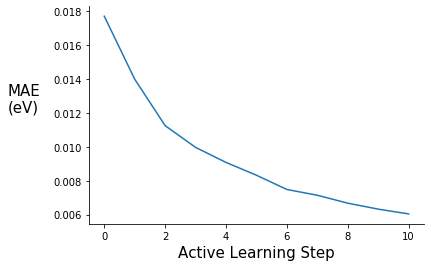

In [52]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(0,11), pe_gpr.metrics["mae"])
ax.set_xlabel("Active Learning Step", fontsize=15)
ax.set_ylabel("MAE\n(eV)", rotation=0, labelpad=30, fontsize=15)
#ax.set_ylim(0.00, 0.14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#plt.title("", fontsize=15)
#ax.legend([], frameon=False)

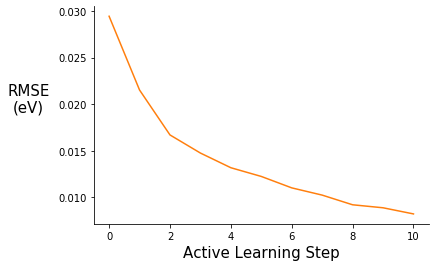

In [53]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(0,11), pe_gpr.metrics["rmse"], c="C1")
ax.set_xlabel("Active Learning Step", fontsize=15)
ax.set_ylabel("RMSE\n(eV)", rotation=0, labelpad=30, fontsize=15)
#ax.set_ylim(0.00, 0.14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#plt.title("", fontsize=15)
#ax.legend([], frameon=False)

## Test MAE and RMSE

In [54]:
pe_gpr.calc_metrics(X_test, y_test)

In [55]:
print("MAE: {mae:0.3f}".format(mae=pe_gpr.metrics["mae"][-1]))
print("RMSE: {rmse:0.3f}".format(rmse=pe_gpr.metrics["rmse"][-1]))
print("R-squared: {r2:0.5f}".format(r2=pe_gpr.metrics["r2"][-1]))

MAE: 0.006
RMSE: 0.008
R-squared: 0.99888


The final MAE and RMSE values are encouraging. For reference, chemical accuracy — the requirement to make useful chemical predictions — is generally considered to be 1 kcal/mol or ~ 0.04 eV. The final MAE value of 0.006 eV is well within in that range, which is great, but there are a few caveats. For one, I used an energy cutoff of 1 eV so that limited the overall energy distribution. It would be interesting to compare my results to randomly guessing energy values within the 1 eV window. Additionally, torsional energy barriers can be low (< 0.025 eV), as a result we would hope that we could resolve those features in the potential energy surface.   

**Comment on the coefficient of determination ($R^2$):** The interpretation of $R^2$ in this context is not entirely clear to me, but it says something about the amount of variance accounted for by the GPR model. It also tells us that our model is better than a model that always predicts the mean value of y regardless of the input features ($R^2$ = 0). **TL;DR** $R^2$ values increase with each active learning step indicating the model is improving.

## Predicting torsion potentials

In [56]:
# torsion potentials are displayed using relative energies
rel_sp_energies = np.array(tor_pot_sp_energies) - min(tor_pot_sp_energies)

In [57]:
rel_tor_predict = [array[0] - min(array[0]) for array in pe_gpr.pred_pot]

In [58]:
# propagate the error (energy – min(energy)) 
tor_std_prop = []
for array in pe_gpr.pred_pot:
    min_index = np.argmin(array[0])
    err_prop = np.sqrt(np.power(array[1], 2) + np.power(array[1][min_index], 2))
    tor_std_prop.append(err_prop)

In [59]:
def tor_pot_plot(rel_energy, rel_predict, std, color, ylim=(-0.2, 0.45)):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(tor_pot_angles, rel_energy)
    ax.plot(tor_pot_angles, rel_predict, "o", c=color)
    #ax.errorbar(tor_pot_angles, rel_predict, yerr=std, fmt="o", c=color)
    ax.fill_between(tor_pot_angles, rel_predict - std, rel_predict + std, alpha=0.125)
    ax.set_xlabel(r"Torsion Angle ($\degree$)", fontsize=15)
    ax.set_ylabel("Relative\nEnergy (eV)", rotation=0, labelpad=50, fontsize=15)
    ax.set_ylim(ylim)
    ax.set_yticks([0.00, 0.15, 0.35])
    ax.set_xticks([0, 180, 360])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.legend(["True", "Predict", "Predict Uncertainty"], loc="upper right", bbox_to_anchor=(1.4 ,1), frameon=False)
    return fig.show()

### Torsion potential after initial training

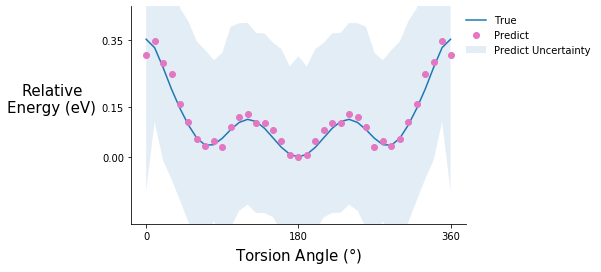

In [60]:
tor_pot_plot(rel_sp_energies, rel_tor_predict[0], tor_std_prop[0], "C6")

### Torsion potential after step 5

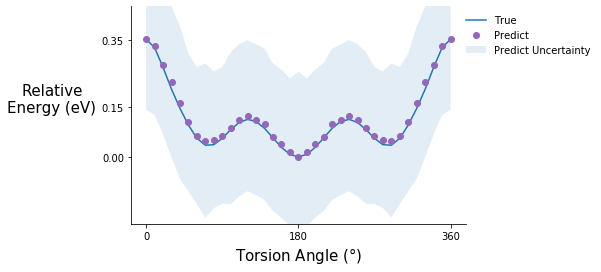

In [61]:
tor_pot_plot(rel_sp_energies, rel_tor_predict[5], tor_std_prop[5], "C4")

### Torsion potential after step 10

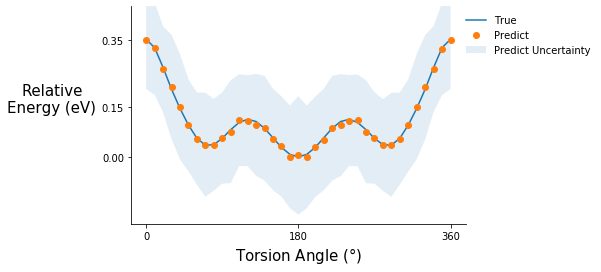

In [62]:
tor_pot_plot(rel_sp_energies, rel_tor_predict[10], tor_std_prop[10], "C1")

**Comment on the torsion potential data**: It is possible that the model saw some of these points during training.

## Predicting relaxed torsion potentials

All the previous data points are single point energies, meaning that I took the initial relaxed structured, rotated the torsion angles, and calculated the energies without doing another relaxation step. Generally, when calculating a torsion potential, I would constrain the torsion angle of interest and do another relaxation. It turns out this is currently not possible with the xTB/ASE combination, but it is very simple to in xTB without the ASE interface. As a result, I read in the files from xTB. The relaxed molecules are guarenteed 

In [63]:
# read in the relaxed molecules
relax_tor_mols = read("./xtbscan.log", index=":", format="xyz")

In [64]:
relax_tor_graphs = [Graph.from_ase(mol, adjacency=adj) for mol in relax_tor_mols]

In [65]:
# read in the energies
relax_tor_ev_energies = []
with open("./xtbscan.log") as file:
    for i, line in enumerate(file):
        if "SCF done" in line:
            # energies are in Hatrees
            tor_ha_energy = float(line.split()[2])
            relax_tor_ev_energies.append(tor_ha_energy * 27.211386245988)  

In [66]:
# relative energies
rel_relax_tor_energies = np.array(relax_tor_ev_energies) - min(relax_tor_ev_energies)

In [67]:
relax_tor_predict, relax_tor_std = pe_gpr.gpr.predict(relax_tor_graphs, return_std=True)

      0.5 ms on generating jobs
      0.4 ms on creating output buffer
      0.8 ms on transferring graphs to GPU
      0.1 ms on allocate global job counter
      8.9 ms on code generation
    193.2 ms on JIT
      0.4 ms on calculating launch configuration
      2.0 ms on GPU kernel execution
    205.6 ms on calling GPU kernel (overall)
      0.0 ms on collecting result


In [68]:
# relative predicted energies
rel_relax_tor_predict = np.array(relax_tor_predict) - min(relax_tor_predict)

In [69]:
# propagate the error (energy – min(energy))
min_i = np.argmin(rel_relax_tor_energies)
relax_tor_std_prop = np.sqrt(np.power(relax_tor_std, 2) + np.power(relax_tor_std[min_i], 2))

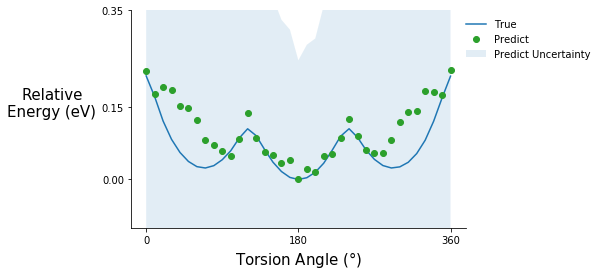

In [70]:
tor_pot_plot(rel_relax_tor_energies, rel_relax_tor_predict, relax_tor_std_prop, "C2", ylim=(-0.1, 0.35))

Predicting the energy of relaxed structures is not fantastic but the shape of the potential is roughly correct, and the good news is that the model knows what it doesn’t know. The prediction uncertainty for these is high compared to the previous torsion potential predictions. Relaxations cause fluctuations in other degrees of freedom such as bond lengths and bond angles, which the model was not trained on. So, if predicting the energy of relaxed structures is the goal some examples should be included in the training set.

# Conclusions

- The graphs and molecular graph kernel from GraphDot have enough resolution to tell the difference between torsional conformers of the same molecule
- Good energy predictions ($<k_BT$) can be achieved on small datasets with the implemented graph kernel and GPR model 
- Prediction uncertainties are very useful and a huge advantage of a GPR model. Chemistry or materials science problems where generating semi-realistic structures is easy but energy evaluations are expensive are most likely to fully leverage the advantages of GPR. 
- If predicting the energy of relaxed structures is the objective, at least some relaxed structures should be included in the training dataset
- The algorithm presented here will not work for all molecular systems but I think everyone can appreciate the software integration :)


## Future Extensions

- Predicting structures — It would be nice to be able to predict low energy conformations. One way to do this is write an optimizer in ASE and use the GPR model as a surrogate for the energy calculation. 
- Extrapolation to larger polymers — One potential way to extend the toy example I presented here is to predict the energy of a chain that is roughly the same size as the torsional correlation length. Beyond that length segments are uncorrelated and one might be able to extrapolate energy predictions to much larger polymers.


## Known Issues

- The validation and test sets are potentially contaminated, because I did not account for the symmetry present in the example system.
- Energies were not calculated on-the-fly in the active learning loop. I did this to keep things simple, but there is no reason it couldn’t be done in the future.